In [1]:
import os

data_path = "/kaggle/input/movie-lens-small-latest-dataset" 
print(os.listdir(data_path))

['movies.csv', 'ratings.csv', 'README.txt', 'tags.csv', 'links.csv']


In [2]:
import pandas as pd

movies = pd.read_csv("/kaggle/input/movie-lens-small-latest-dataset/movies.csv")
df = pd.read_csv("/kaggle/input/movie-lens-small-latest-dataset/ratings.csv")

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
df.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [6]:
import numpy as np

# Creating mappings
user_ids = df["userId"].unique()
movie_ids = df["movieId"].unique()

user2user_encoded = {user_id: idx for idx, user_id in enumerate(user_ids)}
userencoded2user = {idx: user_id for user_id, idx in user2user_encoded.items()}

movie2movie_encoded = {movie_id: idx for idx, movie_id in enumerate(movie_ids)}
movie_encoded2movie = {idx: movie_id for movie_id, idx in movie2movie_encoded.items()}

# Applying mappings
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

# Checks
assert df['user'].isna().sum() == 0, "Missing user mappings"
assert df['movie'].isna().sum() == 0, "Missing movie mappings"

# Final preparation
df['rating'] = df['rating'].astype(np.float32)
num_users = len(user2user_encoded)
num_movies = len(movie2movie_encoded)

print(f"Users: {num_users}, Movies: {num_movies}")
print(f"Ratings: {df['rating'].min():.1f} - {df['rating'].max():.1f}")
print(f"Sparsity: {(1 - len(df)/(num_users * num_movies))*100:.1f}%")

Users: 610, Movies: 9724
Ratings: 0.5 - 5.0
Sparsity: 98.3%


/tmp/ipykernel_2157/1717951555.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


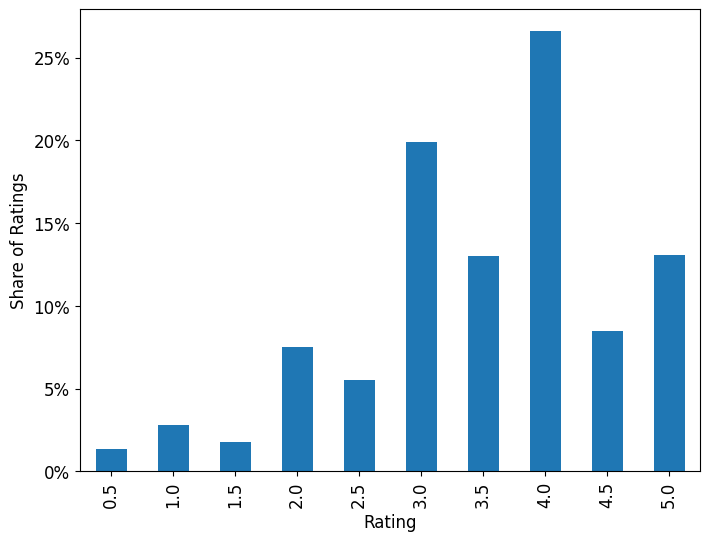

In [7]:
from matplotlib import pyplot as plt    

fig = plt.figure()
ax = df.rating.value_counts(True).sort_index().plot.bar(figsize=(8,6))
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Share of Ratings', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.savefig('Ratings_distribution.png')

In [8]:
from sklearn.model_selection import train_test_split

x = df[["user", "movie"]].values
y = df["rating"].values

x_train, x_val, y_train, y_val = train_test_split(
    x, y, 
    test_size=0.1, 
    random_state=42,
    stratify=y  # Preserve the distribution of ratings
)

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

EMBEDDING_SIZE = 50

class Embedding(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(Embedding, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        
        # User embeddings with regularization
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-4),
            name="user_embedding"
        )
        
        # User biases with regularization
        self.user_bias = layers.Embedding(
            num_users, 1,
            embeddings_initializer="zeros",
            embeddings_regularizer=keras.regularizers.l2(1e-4),
            name="user_bias"
        )
        
        # Movie embeddings with regularization
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-4),
            name="movie_embedding"
        )
        
        # Movie biases with regularization
        self.movie_bias = layers.Embedding(
            num_movies, 1,
            embeddings_initializer="zeros",
            embeddings_regularizer=keras.regularizers.l2(1e-4),
            name="movie_bias"
        )

        # Dropout for regularization
        self.dropout = layers.Dropout(0.2)

    def call(self, inputs, training=None):
        # Extract embeddings
        user_vector = self.user_embedding(inputs[:, 0])      
        user_bias = self.user_bias(inputs[:, 0])            
        movie_vector = self.movie_embedding(inputs[:, 1])   
        movie_bias = self.movie_bias(inputs[:, 1])         
    
        # Apply dropout for regularization
        user_vector = self.dropout(user_vector, training=training)
        movie_vector = self.dropout(movie_vector, training=training)
    
        # Dot product
        dot_user_movie = tf.reduce_sum(user_vector * movie_vector, axis=1, keepdims=True)
    
        # Prediction = dot product + biases
        prediction = dot_user_movie + user_bias + movie_bias
        return prediction

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_users": self.num_users,
            "num_movies": self.num_movies,
            "embedding_size": self.embedding_size
        })
        return config

# Create and compile the model
model = Embedding(num_users, num_movies, EMBEDDING_SIZE)

model.compile(
    loss='mse',
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['mae', 'mse']
)

2025-08-31 16:13:28.570234: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756656808.592128    2157 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756656808.598905    2157 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1756656811.488186    2157 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1756656811.488861    2157 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability:

Epoch 1/100


I0000 00:00:1756656814.315884    2209 service.cc:148] XLA service 0x7ac304007ff0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756656814.315914    2209 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1756656814.315918    2209 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1756656814.435593    2209 cuda_dnn.cc:529] Loaded cuDNN version 90300


  70/1418 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 13.2382 - mae: 3.4891 - mse: 13.2262  

I0000 00:00:1756656815.565375    2209 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1395/1418 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.5005 - mae: 3.1926 - mse: 11.4677
Epoch 1: val_loss improved from inf to 3.63569, saving model to best_recommender_model.h5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 11.4548 - mae: 3.1836 - mse: 11.4207 - val_loss: 3.6357 - val_mae: 1.4904 - val_mse: 3.2929 - learning_rate: 0.0010
Epoch 2/100
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9549 - mae: 1.2715 - mse: 2.5277
Epoch 2: val_loss improved from 3.63569 to 2.25732, saving model to best_recommender_model.h5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2.9547 - mae: 1.2714 - mse: 2.5274 - val_loss: 2.2573 - val_mae: 0.9920 - val_mse: 1.6532 - learning_rate: 0.0010
Epoch 3/100
1407/1418 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0464 - mae: 0.9240 - mse: 1.4107
Epoch 3: val_loss improved from 2.25732 to 2.02372, saving model to best_recommender_model.h5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2.0461 - mae: 0.9239 - mse: 1.4102 - val_loss: 2.0237 -

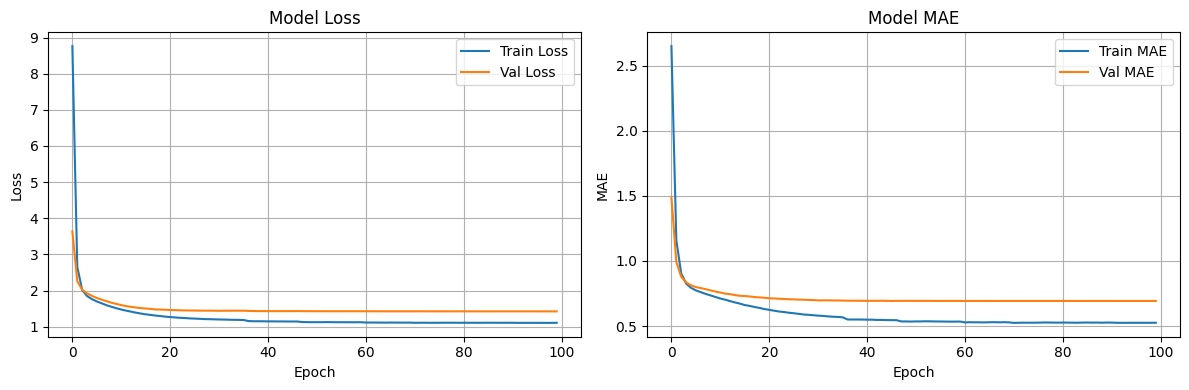


=== Final Results ===
Train - Loss: 1.0717, MAE: 0.5000, MSE: 0.4365
Val   - Loss: 1.4227, MAE: 0.6927, MSE: 0.7876
MAE Gap: 0.1927


In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt

# Callbacks 
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    
    ModelCheckpoint(
        'best_recommender_model.h5',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    )
]

# Training 
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=100,  
    verbose=1,   
    validation_data=(x_val, y_val),
    callbacks=callbacks,
    shuffle=True  
)

# Visualization
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Loss
    ax1.plot(history.history['loss'], label='Train Loss')
    ax1.plot(history.history['val_loss'], label='Val Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # MAE
    ax2.plot(history.history['mae'], label='Train MAE')
    ax2.plot(history.history['val_mae'], label='Val MAE')
    ax2.set_title('Model MAE')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('MAE')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot training curves
plot_training_history(history)

# Final evaluation
train_metrics = model.evaluate(x_train, y_train, verbose=0)
val_metrics = model.evaluate(x_val, y_val, verbose=0)

train_loss, train_mae, train_mse = train_metrics
val_loss, val_mae, val_mse = val_metrics

print(f"\n=== Final Results ===")
print(f"Train - Loss: {train_loss:.4f}, MAE: {train_mae:.4f}, MSE: {train_mse:.4f}")
print(f"Val   - Loss: {val_loss:.4f}, MAE: {val_mae:.4f}, MSE: {val_mse:.4f}")
print(f"MAE Gap: {abs(val_mae - train_mae):.4f}")

Model: "MLP_Recommender"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_id (InputLayer)      │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ movie_id (InputLayer)     │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_embedding            │ (None, 64)             │         39,040 │ user_id[0][0]          │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ movie_embedding           │ (None, 64)             │        622,336 │ movie_id[0][0]         │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_flatten (Flatten)    │ (None, 64)             │              0 │ user_embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ movie_flatten (Flatten)   │ (None, 64)             │              0 │ movie_embedding[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concat_embeddings         │ (None, 128)            │              0 │ user_flatten[0][0],    │
│ (Concatenate)             │                        │                │ movie_flatten[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │         33,024 │ concat_embeddings[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │         32,896 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 64)             │          8,256 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 64)             │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rating_prediction (Dense) │ (None, 1)              │             65 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 735,617 (2.81 MB)

 Trainable params: 735,617 (2.81 MB)

 Non-trainable params: 0 (0.00 B)

Training samples: 90752
Validation samples: 10084
Training ratings range: 0.5 - 5.0
Epoch 1/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 5.1358 - mae: 1.6580 - mse: 4.4941 - val_loss: 1.1973 - val_mae: 0.6919 - val_mse: 0.7944 - learning_rate: 0.0010
Epoch 2/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3718 - mae: 0.7906 - mse: 1.0005 - val_loss: 1.0799 - val_mae: 0.6958 - val_mse: 0.7867 - learning_rate: 0.0010
Epoch 3/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2104 - mae: 0.7618 - mse: 0.9353 - val_loss: 0.9977 - val_mae: 0.6831 - val_mse: 0.7713 - learning_rate: 0.0010
Epoch 4/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1257 - mae: 0.7509 - mse: 0.9110 - val_loss: 0.9446 - val_mae: 0.6746 - val_mse: 0.7596 - learning_rate: 0.0010
Epoch 5/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0599 - mae: 0.7413 - mse: 0.8829 - val_loss: 0.9100 - val_mae: 0.6714 - val_mse: 0.7540 - learning_rate: 0.0010
Epoch 6/100
178/178 ━━━━━━━━━━━━━━━━━━━━

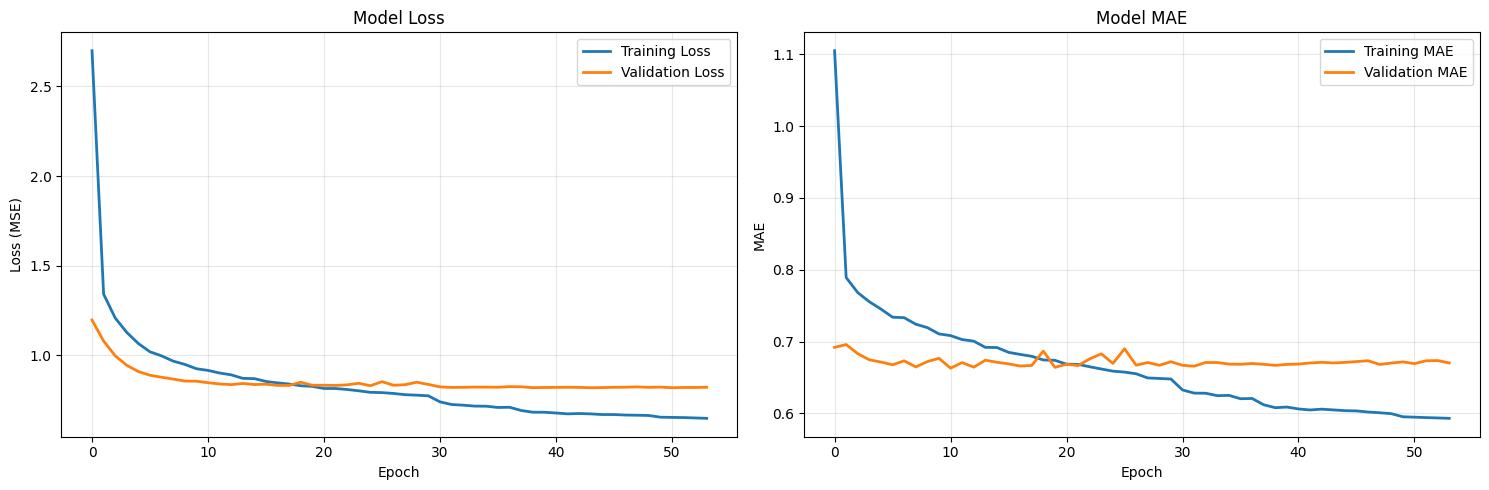

316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MODEL EVALUATION
RMSE: 0.8708
MAE: 0.6702
R²: 0.3021


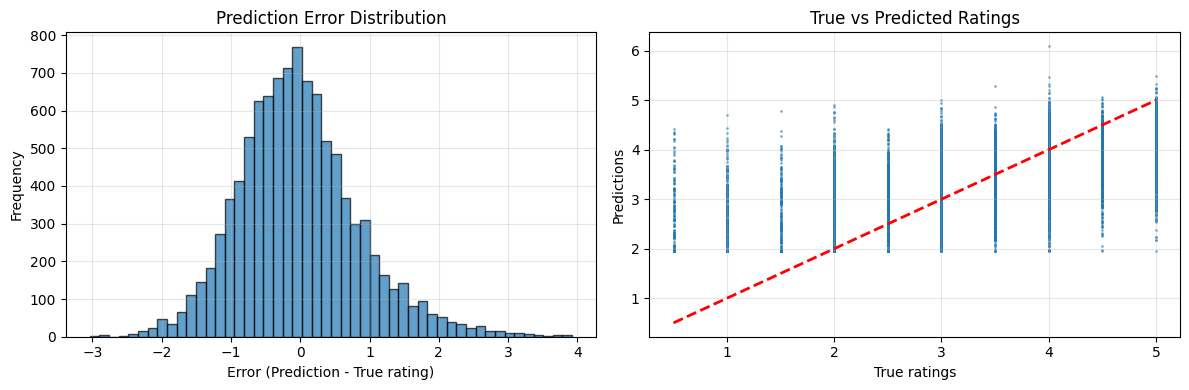

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

def create_mlp_recommendation_model(num_users, num_movies, embedding_dim=64, 
                                  hidden_layers=[256, 128, 64], dropout_rate=0.3, 
                                  l2_reg=0.001):
    
    # Inputs
    user_input = Input(shape=(), name='user_id', dtype='int32')
    movie_input = Input(shape=(), name='movie_id', dtype='int32')
    
    user_embedding = Embedding(
        num_users, embedding_dim, 
        embeddings_regularizer=l2(l2_reg),
        name='user_embedding'
    )(user_input)
    
    movie_embedding = Embedding(
        num_movies, embedding_dim,
        embeddings_regularizer=l2(l2_reg), 
        name='movie_embedding'
    )(movie_input)
    
    # Flatten embeddings
    user_vec = Flatten(name='user_flatten')(user_embedding)
    movie_vec = Flatten(name='movie_flatten')(movie_embedding)
    
    # Concatenate
    concat = Concatenate(name='concat_embeddings')([user_vec, movie_vec])
    
    # MLP hidden layers with dropout and regularization
    x = concat
    for i, units in enumerate(hidden_layers):
        x = Dense(
            units, 
            activation='relu',
            kernel_regularizer=l2(l2_reg),
            name=f'dense_{i+1}'
        )(x)
        x = Dropout(dropout_rate, name=f'dropout_{i+1}')(x)
    
    # Output layer - rating prediction
    output = Dense(1, activation='linear', name='rating_prediction')(x)
    
    # Create model
    model = Model(inputs=[user_input, movie_input], outputs=output, name='MLP_Recommender')
    
    return model

# Create the model
model = create_mlp_recommendation_model(
    num_users=num_users,
    num_movies=num_movies,
    embedding_dim=64,
    hidden_layers=[256, 128, 64],
    dropout_rate=0.3,
    l2_reg=0.001
)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae', 'mse']
)

# Display model architecture
model.summary()


X_train_user = x_train[:, 0]  
X_train_movie = x_train[:, 1]  

X_val_user = x_val[:, 0]
X_val_movie = x_val[:, 1]

print(f"Training samples: {len(X_train_user)}")
print(f"Validation samples: {len(X_val_user)}")
print(f"Training ratings range: {y_train.min():.1f} - {y_train.max():.1f}")


# CALLBACKS FOR TRAINING

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]


# TRAINING THE MODEL

history = model.fit(
    [X_train_user, X_train_movie], y_train,
    validation_data=([X_val_user, X_val_movie], y_val),
    epochs=100,
    batch_size=512,
    callbacks=callbacks,
    verbose=1
)


# VISUALIZATION OF TRAINING RESULTS

def plot_training_history(history):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss
    ax1.plot(history.history['loss'], label='Training Loss', linewidth=2)
    ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss (MSE)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # MAE
    ax2.plot(history.history['mae'], label='Training MAE', linewidth=2)
    ax2.plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
    ax2.set_title('Model MAE')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('MAE')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot training curves
plot_training_history(history)


# MODEL EVALUATION
val_predictions = model.predict([X_val_user, X_val_movie])

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_val, val_predictions)
mae = mean_absolute_error(y_val, val_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, val_predictions)

print("MODEL EVALUATION")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

# Prediction error distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
errors = val_predictions.flatten() - y_val
plt.hist(errors, bins=50, alpha=0.7, edgecolor='black')
plt.title('Prediction Error Distribution')
plt.xlabel('Error (Prediction - True rating)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(y_val, val_predictions.flatten(), alpha=0.5, s=1)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('True ratings')
plt.ylabel('Predictions')
plt.title('True vs Predicted Ratings')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

=== NCF/NeuMF MODEL ARCHITECTURE ===


Model: "NCF_NeuMF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_id (InputLayer)      │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ movie_id (InputLayer)     │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_embedding_mlp        │ (None, 64)             │         39,040 │ user_id[0][0]          │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ movie_embedding_mlp       │ (None, 64)             │        622,336 │ movie_id[0][0]         │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_flatten_mlp          │ (None, 64)             │              0 │ user_embedding_mlp[0]… │
│ (Flatten)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ movie_flatten_mlp         │ (None, 64)             │              0 │ movie_embedding_mlp[0… │
│ (Flatten)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mlp_concat (Concatenate)  │ (None, 128)            │              0 │ user_flatten_mlp[0][0… │
│                           │                        │                │ movie_flatten_mlp[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mlp_dense_1 (Dense)       │ (None, 128)            │         16,512 │ mlp_concat[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mlp_dropout_1 (Dropout)   │ (None, 128)            │              0 │ mlp_dense_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mlp_dense_2 (Dense)       │ (None, 64)             │          8,256 │ mlp_dropout_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_embedding_gmf        │ (None, 32)             │         19,520 │ user_id[0][0]          │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ movie_embedding_gmf       │ (None, 32)             │        311,168 │ movie_id[0][0]         │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mlp_dropout_2 (Dropout)   │ (None, 64)             │              0 │ mlp_dense_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_flatten_gmf          │ (None, 32)             │              0 │ user_embedding_gmf[0]… │
│ (Flatten)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ movie_flatten_gmf         │ (None, 32)             │              0 │ movie_embedding_gmf[0… │
│ (Flatten)                 │                        │                │                        │
├──────────────────────

 Total params: 1,018,977 (3.89 MB)

 Trainable params: 1,018,977 (3.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 7.2882 - mae: 2.1987 - mse: 6.8506 - val_loss: 1.1508 - val_mae: 0.7158 - val_mse: 0.8254 - learning_rate: 0.0010
Epoch 2/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.6177 - mae: 0.9126 - mse: 1.3129 - val_loss: 1.0453 - val_mae: 0.6947 - val_mse: 0.7919 - learning_rate: 0.0010
Epoch 3/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.4496 - mae: 0.8737 - mse: 1.2082 - val_loss: 1.0163 - val_mae: 0.7126 - val_mse: 0.8092 - learning_rate: 0.0010
Epoch 4/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3673 - mae: 0.8597 - mse: 1.1692 - val_loss: 0.9754 - val_mae: 0.7056 - val_mse: 0.8013 - learning_rate: 0.0010
Epoch 5/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2987 - mae: 0.8441 - mse: 1.1311 - val_loss: 0.9418 - val_mae: 0.7019 - val_mse: 0.7944 - learning_rate: 0.0010
Epoch 6/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2453 - mae: 0.8329 - mse: 1.1028 - val_loss: 0.9096 - val_ma

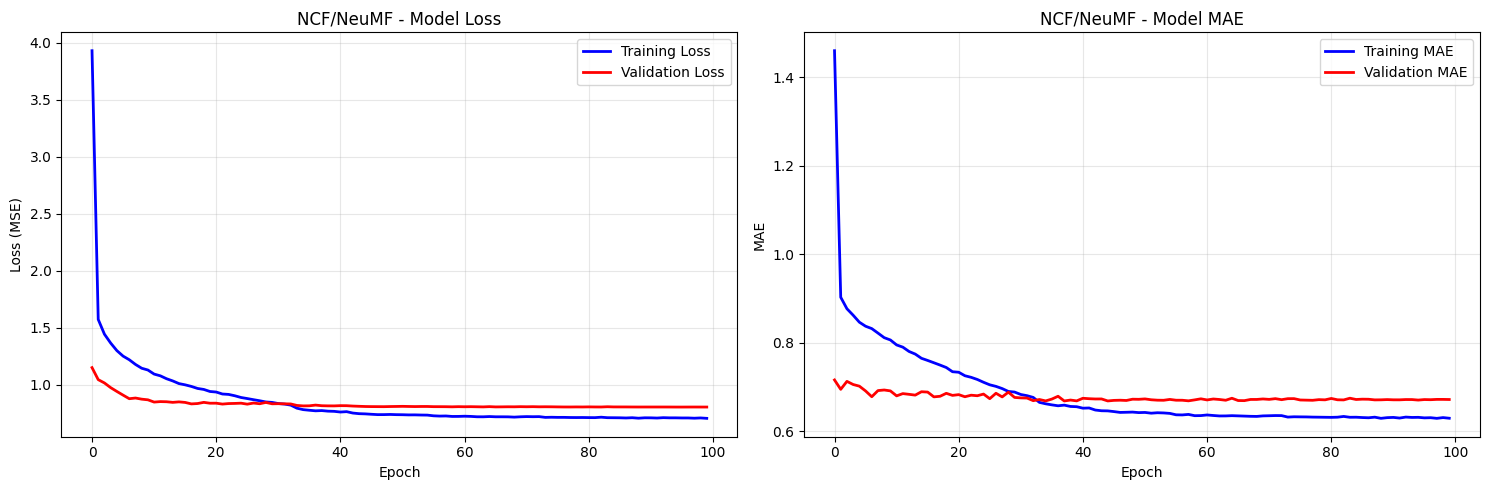

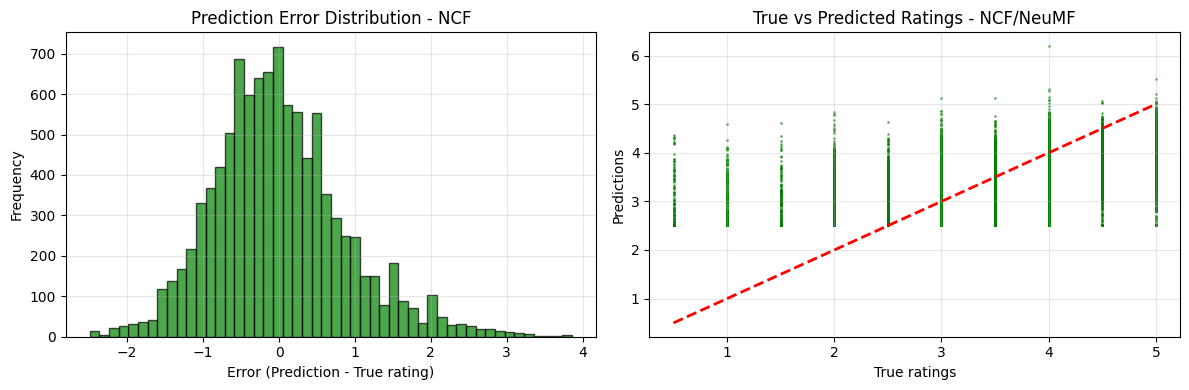

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate, Dropout, Multiply
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np

def create_ncf_model(num_users, num_movies, 
                     gmf_dim=32, mlp_dim=64, 
                     hidden_layers=[128, 64, 32], 
                     dropout_rate=0.3, l2_reg=0.001):
   
    # INPUTS
    user_input = Input(shape=(), name='user_id', dtype='int32')
    movie_input = Input(shape=(), name='movie_id', dtype='int32')
    
    # GMF (Generalized Matrix Factorization)
    # Separate embeddings for GMF
    user_embedding_gmf = Embedding(
        num_users, gmf_dim,
        embeddings_initializer='he_normal',
        embeddings_regularizer=l2(l2_reg),
        name='user_embedding_gmf'
    )(user_input)
    
    movie_embedding_gmf = Embedding(
        num_movies, gmf_dim,
        embeddings_initializer='he_normal',
        embeddings_regularizer=l2(l2_reg),
        name='movie_embedding_gmf'
    )(movie_input)
    
    # Flatten GMF embeddings
    user_vec_gmf = Flatten(name='user_flatten_gmf')(user_embedding_gmf)
    movie_vec_gmf = Flatten(name='movie_flatten_gmf')(movie_embedding_gmf)
    
    # Element-wise product for GMF
    gmf_output = Multiply(name='gmf_multiply')([user_vec_gmf, movie_vec_gmf])
    
    # MLP (Multi-Layer Perceptron)
    # Separate embeddings for MLP
    user_embedding_mlp = Embedding(
        num_users, mlp_dim,
        embeddings_initializer='he_normal',
        embeddings_regularizer=l2(l2_reg),
        name='user_embedding_mlp'
    )(user_input)
    
    movie_embedding_mlp = Embedding(
        num_movies, mlp_dim,
        embeddings_initializer='he_normal',
        embeddings_regularizer=l2(l2_reg),
        name='movie_embedding_mlp'
    )(movie_input)
    
    # Flatten MLP embeddings
    user_vec_mlp = Flatten(name='user_flatten_mlp')(user_embedding_mlp)
    movie_vec_mlp = Flatten(name='movie_flatten_mlp')(movie_embedding_mlp)
    
    # Concatenate embeddings for MLP
    mlp_concat = Concatenate(name='mlp_concat')([user_vec_mlp, movie_vec_mlp])
    
    # MLP hidden layers
    mlp_output = mlp_concat
    for i, units in enumerate(hidden_layers):
        mlp_output = Dense(
            units,
            activation='relu',
            kernel_regularizer=l2(l2_reg),
            name=f'mlp_dense_{i+1}'
        )(mlp_output)
        mlp_output = Dropout(dropout_rate, name=f'mlp_dropout_{i+1}')(mlp_output)
    
    # NCF FUSION
    # Concatenate GMF and MLP outputs
    ncf_concat = Concatenate(name='ncf_concat')([gmf_output, mlp_output])
    
    # Final prediction layer
    output = Dense(1, activation='linear', name='rating_prediction')(ncf_concat)
    
    # Create the model
    model = Model(inputs=[user_input, movie_input], outputs=output, name='NCF_NeuMF')
    
    return model


# CREATE NCF MODEL
ncf_model = create_ncf_model(
    num_users=num_users,
    num_movies=num_movies,
    gmf_dim=32,
    mlp_dim=64,
    hidden_layers=[128, 64, 32],
    dropout_rate=0.3,
    l2_reg=0.001
)

# Compile
ncf_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae', 'mse']
)

print("=== NCF/NeuMF MODEL ARCHITECTURE ===")
ncf_model.summary()


# PREPARE DATA FOR NCF
X_train_user = x_train[:, 0]
X_train_movie = x_train[:, 1]
X_val_user = x_val[:, 0]
X_val_movie = x_val[:, 1]


# CALLBACKS FOR NCF
ncf_callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,
        min_lr=1e-6,
        verbose=1
    )
]


# TRAINING NCF MODEL
history_ncf = ncf_model.fit(
    [X_train_user, X_train_movie], y_train,
    validation_data=([X_val_user, X_val_movie], y_val),
    epochs=100,
    batch_size=512,
    callbacks=ncf_callbacks,
    verbose=1
)


# EVALUATION AND COMPARISON
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# NCF predictions
val_predictions_ncf = ncf_model.predict([X_val_user, X_val_movie])

mse_ncf = mean_squared_error(y_val, val_predictions_ncf)
mae_ncf = mean_absolute_error(y_val, val_predictions_ncf)
rmse_ncf = np.sqrt(mse_ncf)
r2_ncf = r2_score(y_val, val_predictions_ncf)

print("\nNCF/NeuMF MODEL EVALUATION")
print(f"RMSE: {rmse_ncf:.4f}")
print(f"MAE: {mae_ncf:.4f}")
print(f"R²: {r2_ncf:.4f}")


# VISUALIZE TRAINING RESULTS
def plot_ncf_training_history(history):
    """Visualize NCF training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss
    ax1.plot(history.history['loss'], label='Training Loss', linewidth=2, color='blue')
    ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='red')
    ax1.set_title('NCF/NeuMF - Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss (MSE)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # MAE
    ax2.plot(history.history['mae'], label='Training MAE', linewidth=2, color='blue')
    ax2.plot(history.history['val_mae'], label='Validation MAE', linewidth=2, color='red')
    ax2.set_title('NCF/NeuMF - Model MAE')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('MAE')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_ncf_training_history(history_ncf)

# Prediction error distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
errors_ncf = val_predictions_ncf.flatten() - y_val
plt.hist(errors_ncf, bins=50, alpha=0.7, edgecolor='black', color='green')
plt.title('Prediction Error Distribution - NCF')
plt.xlabel('Error (Prediction - True rating)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(y_val, val_predictions_ncf.flatten(), alpha=0.5, s=1, color='green')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('True ratings')
plt.ylabel('Predictions')
plt.title('True vs Predicted Ratings - NCF/NeuMF')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()